In [90]:
import pyximport; pyximport.install()
import gc
import time
import numpy as np
import pandas as pd
# from joblib import Parallel, delayed
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDRegressor
import lightgbm as lgb
from PyQt5 import QtCore, QtGui
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
%matplotlib inline

In [91]:
train=pd.read_table('train.tsv', engine='c')

In [92]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [93]:
round(train['price'].describe())

count    1482535.0
mean          27.0
std           39.0
min            0.0
25%           10.0
50%           17.0
75%           29.0
max         2009.0
Name: price, dtype: float64

Text(0.5, 0, 'Price')

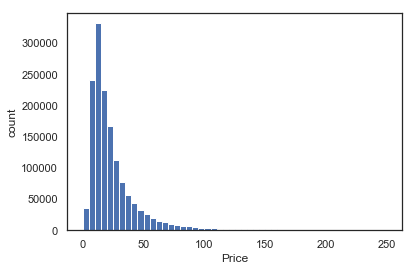

In [94]:
plt.hist(train.price,bins=50,range=(0,250))
plt.ylabel('count')
plt.xlabel('Price')

(array([0.00000e+00, 0.00000e+00, 1.87030e+04, 1.61390e+04, 1.16079e+05,
        2.64518e+05, 3.17012e+05, 2.68209e+05, 2.24673e+05, 1.22655e+05,
        7.17360e+04, 3.22540e+04, 1.68910e+04, 7.68800e+03, 3.19600e+03,
        1.16600e+03, 4.90000e+02, 1.84000e+02, 5.80000e+01, 1.00000e+01]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8,
        5.2, 5.6, 6. , 6.4, 6.8, 7.2, 7.6, 8. ]),
 <a list of 20 Patch objects>)

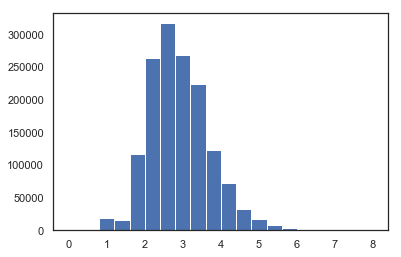

In [95]:
lt=train.price.apply(np.log)
plt.hist(lt,bins=20,range=(0,8))
# log transformation

In [96]:
bn=train['brand_name'].value_counts().loc[lambda x : x.index != 'missing']
NUM_BRANDS = len(bn) - len(bn[bn<=4])
NUM_BRANDS

2390

In [97]:
len(bn)

4809

In [98]:
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [99]:
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))

In [100]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [101]:
def handle_missing_inplace(dataset):
    dataset['general_cat'].fillna(value='missing', inplace=True)
    dataset['subcat_1'].fillna(value='missing', inplace=True)
    dataset['subcat_2'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)

In [102]:
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category1 = dataset['general_cat'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    pop_category2 = dataset['subcat_1'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    pop_category3 = dataset['subcat_2'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    dataset.loc[~dataset['general_cat'].isin(pop_category1), 'general_cat'] = 'missing'
    dataset.loc[~dataset['subcat_1'].isin(pop_category2), 'subcat_1'] = 'missing'
    dataset.loc[~dataset['subcat_2'].isin(pop_category3), 'subcat_2'] = 'missing'

In [103]:
def to_categorical(dataset):
    dataset['general_cat'] = dataset['general_cat'].astype('category')
    dataset['subcat_1'] = dataset['subcat_1'].astype('category')
    dataset['subcat_2'] = dataset['subcat_2'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [104]:
nrow_test = train.shape[0]
nrow_test

1482535

In [105]:
dftt = train[(train.price < 1.0)] # get rid of low price products
train = train.drop(train[(train.price < 1.0)].index)
nrow_train = train.shape[0]
nrow_train

1481661

In [106]:
start_time = time.time()

merge: pd.DataFrame = pd.concat([train, dftt])
y = np.log1p(merge["price"])
del merge['price']

del train
gc.collect()

82

In [107]:
start_time = time.time()

merge['general_cat'], merge['subcat_1'], merge['subcat_2'] = zip(*merge['category_name'].apply(lambda x: split_cat(x)))
merge.drop('category_name', axis=1, inplace=True)
print('{} splitting time'.format(time.time() - start_time))

handle_missing_inplace(merge)
print('[{}] processing missing value time.'.format(time.time() - start_time))

cutting(merge)
print('[{}] processing popular brand time.'.format(time.time() - start_time))

to_categorical(merge)
print('[{}] categorical time'.format(time.time() - start_time))

cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])
print('[{}] Count vectorize `name` completed.'.format(time.time() - start_time))

cv = CountVectorizer()
X_category1 = cv.fit_transform(merge['general_cat'])
X_category2 = cv.fit_transform(merge['subcat_1'])
X_category3 = cv.fit_transform(merge['subcat_2'])
print('[{}] categories vectorize time.'.format(time.time() - start_time))

22.737541913986206 splitting time
[23.662763833999634] processing missing value time.
[25.97149896621704] processing popular brand time.
[27.77360486984253] categorical time
[36.84097218513489] Count vectorize `name` completed.
[51.865829944610596] categories vectorize time.


In [108]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION,
                     ngram_range=(1, 3),
                     stop_words='english')

X_description = tv.fit_transform(merge['item_description'])
print('[{}] TFidf time.'.format(time.time() - start_time))

lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])
print('[{}] one hot encoding time .'.format(time.time() - start_time))

X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']],
                                      sparse=True).values)
print('[{}] categorical time.'.format(time.time() - start_time))

sparse_merge = hstack((X_dummies, X_description, X_brand, X_category1, X_category2, X_category3, X_name)).tocsr()
print('[{}] get strunctural'.format(time.time() - start_time))

[740.5939748287201] TFidf time.
[815.5547270774841] one hot encoding time .
[820.4755170345306] categorical time.
[828.6913909912109] get strunctural


In [109]:
train_X, test_X, train_y, test_y = train_test_split(sparse_merge, y, test_size = 0.1, random_state = 144) 

In [110]:
model = Ridge(alpha=.5, copy_X=True, fit_intercept=True, max_iter=100,
  normalize=False, random_state=101, solver='auto', tol=0.01)

model.fit(train_X, train_y)
print('[{}] Train ridge completed'.format(time.time() - start_time))
predsR = model.predict(X=test_X)
print('[{}] Predict ridge completed'.format(time.time() - start_time))

rmsleR = rmsle(predsR, test_y)
rmsle(np.expm1(predsR), np.expm1(test_y))
np.sqrt(mean_squared_error(np.expm1(predsR), np.expm1(test_y)))
print(rmsle(np.expm1(predsR), np.expm1(test_y)))

[2103.625298976898] Train ridge completed
[2103.778207063675] Predict ridge completed
0.4676692829338066


In [111]:
pred_true_df = pd.concat([pd.DataFrame(predsR),pd.DataFrame(test_y.reset_index() )], axis = 1)
del pred_true_df['index']
pred_true_df.columns = ['Pred_price', 'true_price']
pred_true_df['Pred_price'] = np.expm1(pred_true_df['Pred_price'] )
pred_true_df['true_price'] = np.expm1(pred_true_df['true_price'] )

pred_true_df.head(10)

,Pred_price,true_price
0,10.358160,9.0
1,67.045963,11.0
2,22.274259,40.0
3,13.230861,22.0
4,22.687168,84.0
5,14.538117,12.0
6,16.043766,14.0
7,41.230068,26.0
8,27.934199,23.0
9,29.928211,36.0


In [113]:
print( 'true>predict' + str(len(pred_true_df[pred_true_df['true_price']>pred_true_df['Pred_price'] ])) )

print( 'true<predict' + str(len(pred_true_df[pred_true_df['true_price']<pred_true_df['Pred_price'] ])) )

(pred_true_df['Pred_price'] -  pred_true_df['true_price']).mean()

true>predict71759
true<predict76495


-3.3902970367779015